## 1. Обзор данных
В этой части рассматривается выборка данных с целью ознакомления. В репозитории находятся немного другие данные, по причине того, что объем данных не позволяет загрузить все.

Загрузим готовые результаты подсчета проекций (бинарный файл, записанные подряд структуры).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import scipy.stats as sps
import imageio
import seaborn as sns
import os
import time

from sklearn.model_selection import train_test_split

from collections import defaultdict

import torch
from torch import nn

import nn_architectures
import nn_tools
import data_load

import warnings
warnings.filterwarnings('ignore')

#sns.set(font_scale=1.3)
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [2]:
data = data_load.load_dataset('./data_part/')
data.head()

,PupX,PupY,PupR,IriX,IriY,IriR,1,2,3,4,...,631,632,633,634,635,636,637,638,639,640
Filename,,,,,,,,,,,,,,,,,,,,,
2463(r-1-1)101231-233000_e_00_0000.bmp,391,263,45,392,263,121,0,0,0,0,...,1651,1665,1637,1596,1496,1400,1212,1012,801,607
2463(r-1-1)101231-233000_e_00_0001.bmp,392,261,37,396,261,120,0,0,0,0,...,2639,2544,2358,2119,1893,1707,1972,2235,2490,2753
2463(r-1-1)101231-233000_e_00_0002.bmp,385,270,36,389,270,120,0,0,0,0,...,2014,1835,1721,1688,1628,1629,1927,2254,2625,3028
2463(r-1-1)101231-233000_e_00_0003.bmp,292,273,34,296,273,120,0,0,0,0,...,1594,1800,1977,2195,2338,2451,2269,2027,1746,1433
2463(r-1-1)101231-233000_e_00_0004.bmp,363,262,38,367,262,119,1017,1017,1017,1017,...,1820,1782,1746,1708,1668,1662,1489,1281,1024,807


Рассмотрим сами проекции. Рассматривать надо 640 проекций, поскольку в силу ограничения размером картинки дальше может быть только некоторый шум.

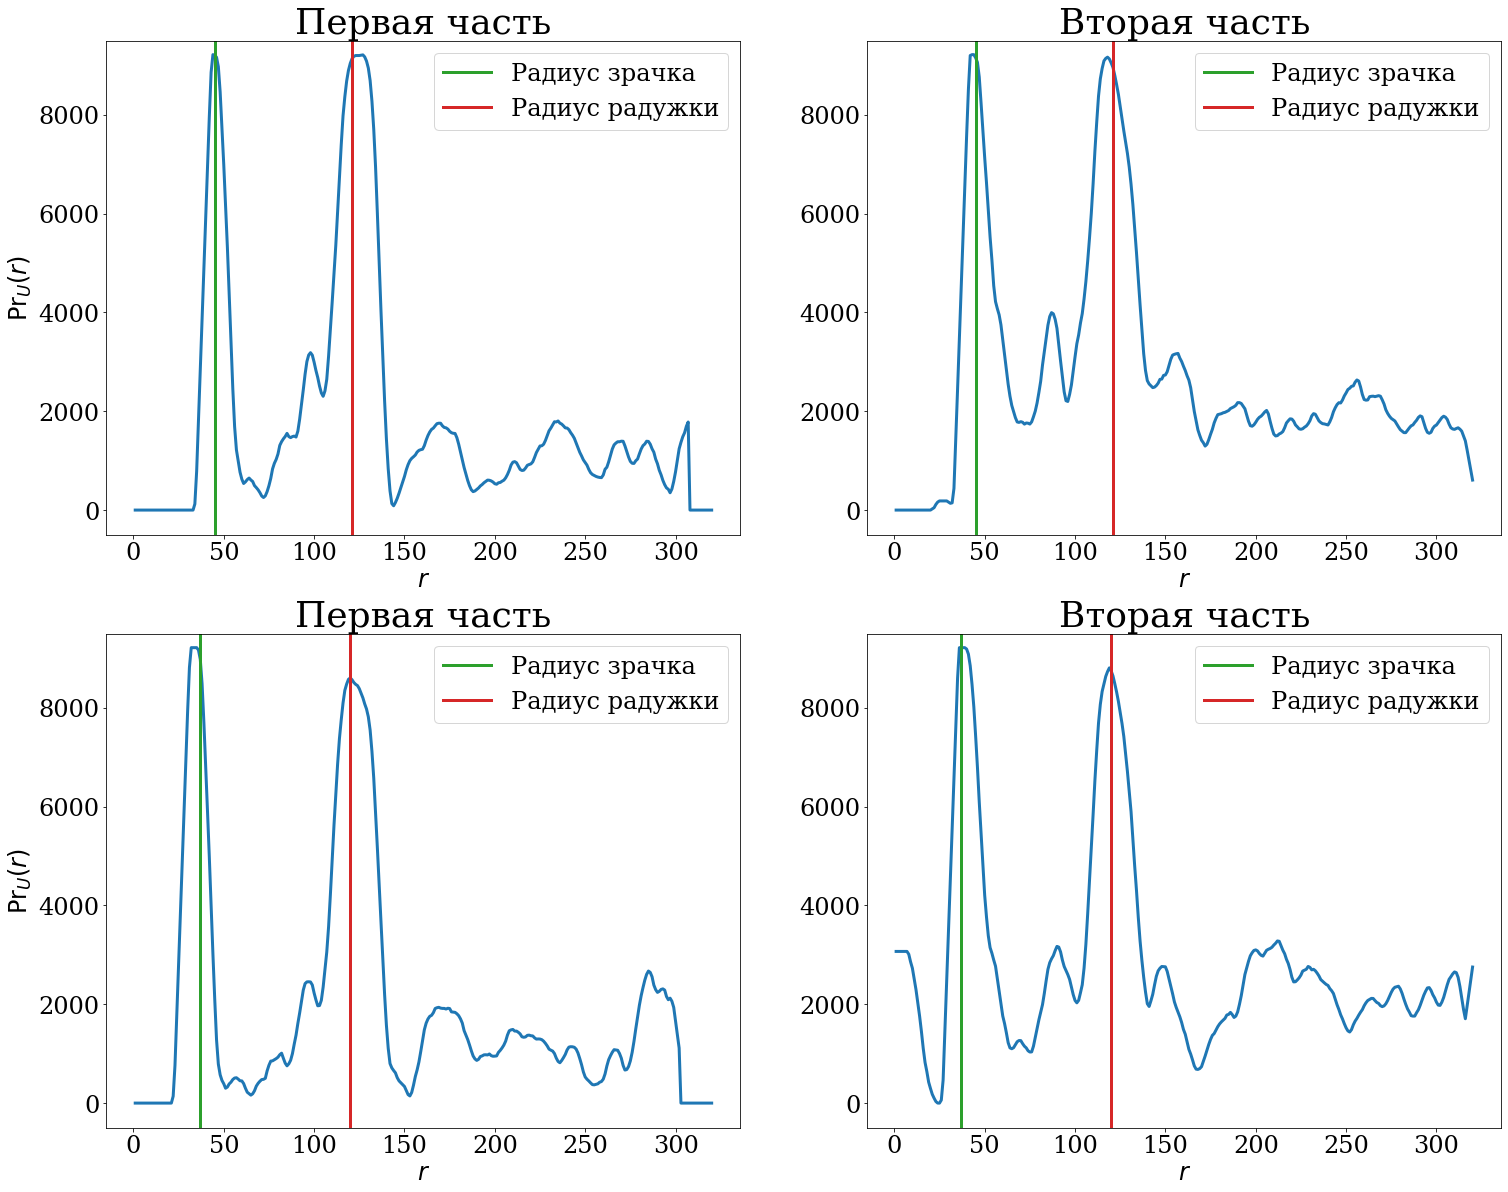

In [3]:
plt.figure(figsize=(25, 20))
for i in range(2):
    plt.subplot(2, 2, 2 * i + 1)
    plt.plot(data.loc[data.index[i], np.arange(1, 321)])
    plt.axvline(data.loc[data.index[i], 'PupR'], color='C2', label='Радиус зрачка')
    plt.axvline(data.loc[data.index[i], 'IriR'], color='C3', label='Радиус радужки')
    plt.title('Первая часть')
    plt.xlabel('$r$')
    plt.ylabel('$\\mathsf{Pr}_U(r)$')
    #plt.ylabel(f'Изображение {i+1}')
    plt.legend()
    plt.ylim((-500, 9500))
    
    plt.subplot(2, 2, 2 * i + 2)
    plt.plot(np.arange(1, 321), data.loc[data.index[i], np.arange(321, 641)])
    plt.axvline(data.loc[data.index[i], 'PupR'], color='C2', label='Радиус зрачка')
    plt.axvline(data.loc[data.index[i], 'IriR'], color='C3', label='Радиус радужки')
    plt.title('Вторая часть')
    plt.xlabel('$r$')
    plt.legend()
    plt.ylim((-500, 9500))

## 2. Вычислительный эксперимент

В данной части происходит обучение нейронной сети и ее выяснение ее возможностей.

In [4]:
sample = data[np.arange(1, 641)].to_numpy() / 9500
target = data[['PupR', 'IriR']].to_numpy()

In [5]:
train_sample, test_sample, train_target, test_target = train_test_split(
    sample, target, test_size=0.2, random_state=42
)
train_sample, val_sample, train_target, val_target = train_test_split(
    train_sample, train_target, test_size=1/5, random_state=42
)

In [6]:
train_sample.shape, train_target.shape

((5492, 640), (5492, 2))

In [7]:
val_sample.shape, val_target.shape

((1373, 640), (1373, 2))

In [8]:
test_sample.shape, test_target.shape

((1717, 640), (1717, 2))

In [9]:
train_sample_torch = torch.reshape(
    torch.tensor(train_sample, dtype=torch.float32),
    (train_sample.shape[0], 2, 320)
)
test_sample_torch = torch.reshape(
    torch.tensor(test_sample, dtype=torch.float32),
    (test_sample.shape[0], 2, 320)
)
train_target_torch = torch.tensor(train_target, dtype=torch.float32)
test_target_torch = torch.tensor(test_target, dtype=torch.float32)

In [10]:
def conv_train_iter(exec_no):
    conv_net = nn_architectures.Convolutional3Layers()
    criterion = nn.MSELoss()
    conv_optimizer = torch.optim.Adam(conv_net.parameters(), lr=3e-3)
    history = nn_tools.train(
        conv_net, criterion, conv_optimizer,
        train_sample_torch, train_target_torch,
        test_sample_torch, test_target_torch,
        batch_size=128, num_epochs=200,
        save_path='out/conv{}.model'.format(exec_no),
        ylim=(0, 20)
    )
    return history

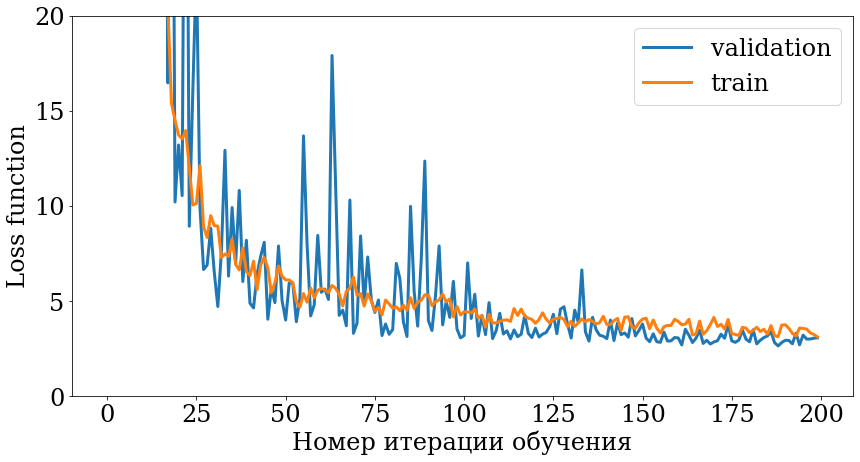

In [11]:
history = nn_tools.accumulate_histories(conv_train_iter, num_executions=10)

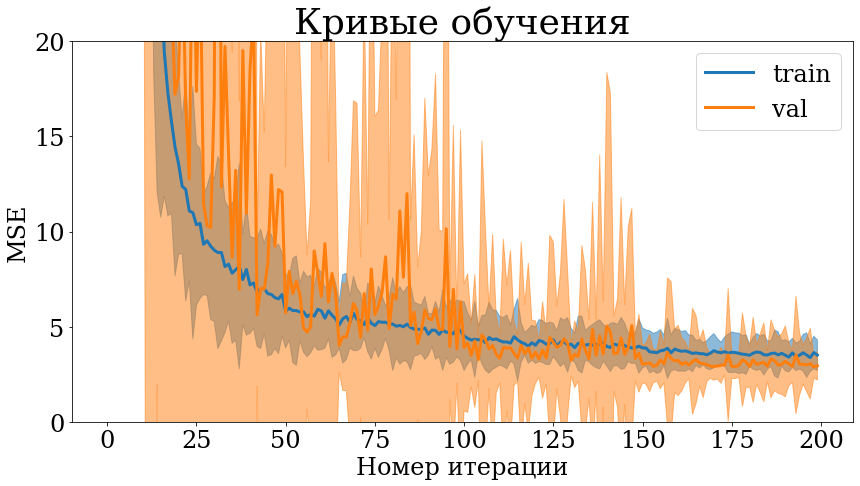

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(history['mean']['train'], label='train')
plt.fill_between(
    np.arange(len(history['mean']['train'])),
    history['mean']['train'] - 2.95 * history['std']['train'],
    history['mean']['train'] + 2.95 * history['std']['train'],
    color='C0', alpha=0.5)
plt.plot(history['mean']['val'], label='val')
plt.fill_between(
    np.arange(len(history['mean']['val'])),
    history['mean']['val'] - 2.95 * history['std']['val'],
    history['mean']['val'] + 2.95 * history['std']['val'],
    color='C1', alpha=0.5)
plt.legend()
plt.ylim((0, 20))
plt.title('Кривые обучения')
plt.xlabel('Номер итерации')
plt.ylabel('MSE');

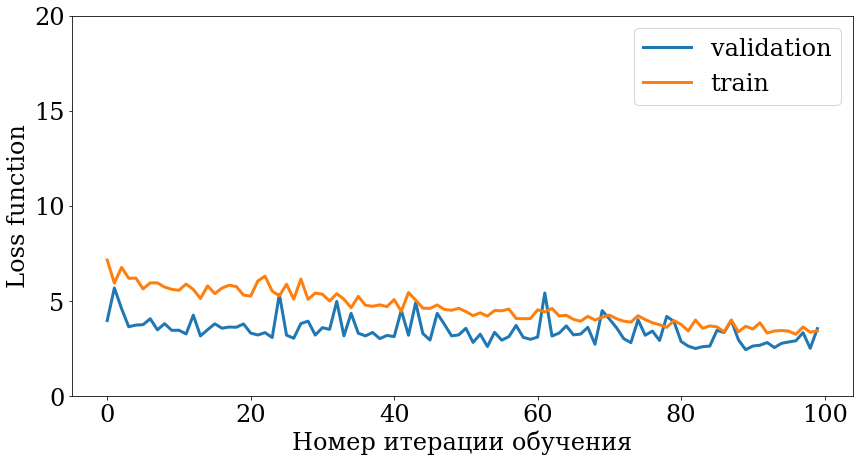

In [26]:
history = nn_tools.train(
    conv_net, criterion, conv_optimizer,
    train_sample_torch, train_target_torch,
    test_sample_torch, test_target_torch,
    batch_size=64, num_epochs=100,
    save_path='out/conv.model',
    ylim=(0, 20)
)

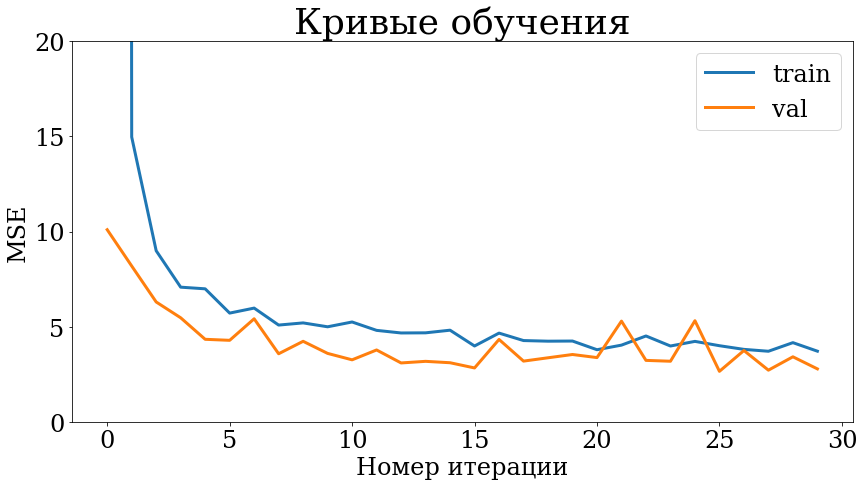

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(history['loss']['train'], label='train')
plt.plot(history['loss']['val'], label='val')
plt.legend()
plt.ylim((0, 20))
plt.title('Кривые обучения')
plt.xlabel('Номер итерации')
plt.ylabel('MSE');

In [13]:
linnet = nn_architectures.Linear2Layers()
lincriterion = nn.MSELoss()
lin_optimizer = torch.optim.SGD(linnet.parameters(), lr=1e-3, momentum=0.9)

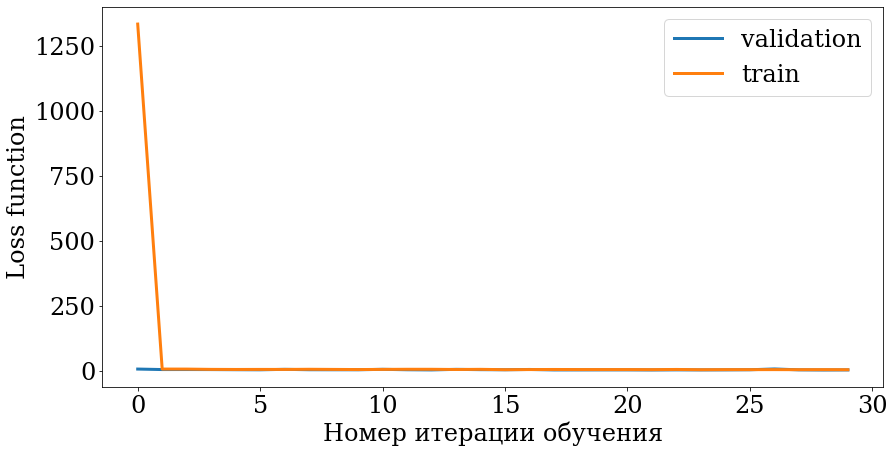

In [14]:
lin_history = nn_tools.train(
    linnet, lincriterion, lin_optimizer,
    train_sample_torch, train_target_torch,
    test_sample_torch, test_target_torch,
    batch_size=64, num_epochs=30
)

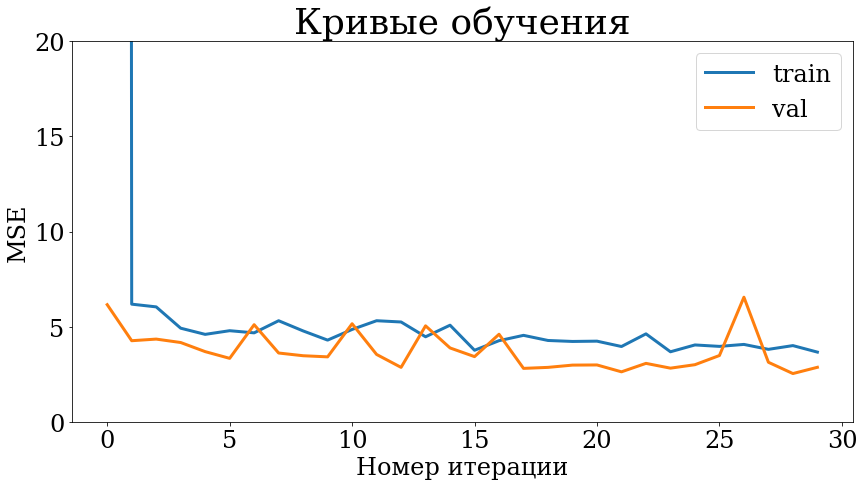

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(lin_history['loss']['train'], label='train')
plt.plot(lin_history['loss']['val'], label='val')
plt.legend()
plt.ylim((0, 20))
plt.title('Кривые обучения')
plt.xlabel('Номер итерации')
plt.ylabel('MSE');

Сравнительные графики моделей:

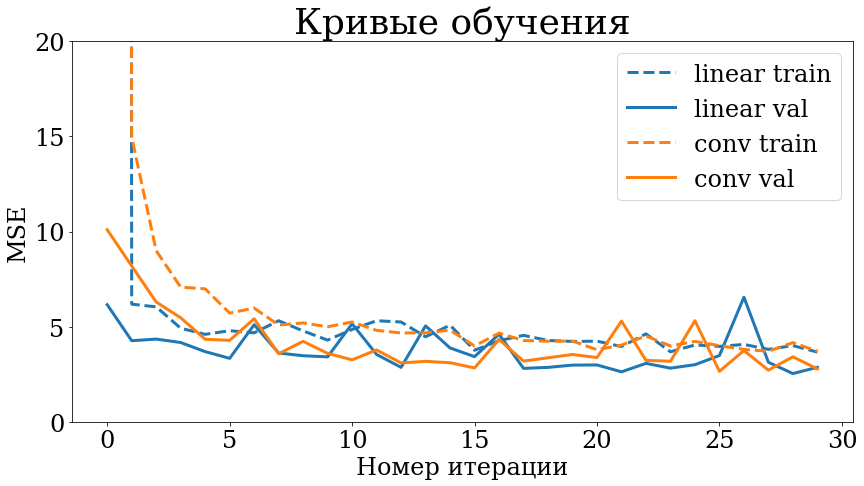

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(lin_history['loss']['train'], color='C0', ls='--', label='linear train')
plt.plot(lin_history['loss']['val'], color='C0', label='linear val')
plt.plot(history['loss']['train'], color='C1', ls='--', label='conv train')
plt.plot(history['loss']['val'], color='C1', label='conv val')
plt.legend()
plt.ylim((0, 20))
plt.title('Кривые обучения')
plt.xlabel('Номер итерации')
plt.ylabel('MSE');